In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp
import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.geometry.mappings_analytical       as mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import numpy             as np
import matplotlib.pyplot as plt

import hylife.utilitis_FEEC.projectors_global as proj_glob
import hylife.utilitis_FEEC.evaluation as eva

import hylife.utilitis_FEEC.bsplines as bsp
import hylife.utilitis_FEEC.derivatives          as derivatives


In [213]:
def ini_par(
    L=2.,
    deg=3,
    bc = True,
    Nel = 4,
    Nq = 6,
    dt=0.001):
    args_map=[1, [L,L,L]]
    fun = lambda xi1 : np.sin( np.pi*( np.sin(2.*np.pi*xi1) ) )
    el_b = np.linspace(0., L, Nel + 1)
    xi1=np.array(el_b)
    xi2=np.array([0])
    xi3=np.array([0])
    df_inv=mapping.df_inv(xi1, xi2, xi3, *args_map, 1*10+1)
    v=1
    p=deg
    T = bsp.make_knots(el_b, p, bc)
    obj = proj_glob.projectors_1d(T, p, bc, Nq)
    coeffs = obj.PI_1(fun)
    Int_mat_inv=np.linalg.inv(obj.N.todense())
    Eva_mat=bsp.collocation_matrix(T[1:-1], p - 1, obj.greville, bc, normalize=True)
    der = derivatives.GRAD_1d(T, p, bc)
    #print('Parameters Intialization done')
    return L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,obj,coeffs,Int_mat_inv,der,Eva_mat

In [214]:
[L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,
 obj,coeffs,Int_mat_inv,der,Eva_mat]=ini_par()

### Von Neuman stability Euler Explicit

In [253]:
def VNE(Nel,deg,dt):
    [L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,
     v,T,obj,coeffs,Int_mat_inv,der,Eva_mat]=ini_par(
    Nel=Nel,deg=deg,dt=dt)
    alpha=v*dt*df_inv
    LM=[]
    Lint=len(Int_mat_inv)
    N=np.linspace(0,Lint-1,Lint).astype(int)
    for i in LIN:
        real_lam=(1-alpha*
        np.sum([der.dot(Int_mat_inv).dot(Eva_mat)[i,j]*np.cos(2*np.pi/Nel*(j-i)*i) 
                for j in N]))
        
        im_lam=-alpha*np.sum([der.dot(Int_mat_inv).dot(Eva_mat)[i,j]
        *np.sin(2*np.pi/Nel*(j-i)*i) for j in N])
        z=complex(real_lam,im_lam)
        LM.append(np.sqrt((z*z.conjugate()).real))
        if  len([i for i,j in enumerate(np.array(LM)>1.0001) if j==True])>0:
            col=1
        else:
            col=0
    return LM, col
VNE(Nel,3,dt)

([1.0000000000000002,
  1.1809648315914192,
  1.6037333872503692,
  2.1128229182209326],
 1)

#### Runge Khutta Von Neumann Staibilty

In [248]:
#Corrected Von Neumann Analyisis
def VNRK(Nel,deg,dt):
    [L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,
     v,T,obj,coeffs,Int_mat_inv,der,Eva_mat]=ini_par(
    Nel=Nel,deg=deg,dt=dt)
    alpha=dt*v*df_inv
    LM=[]
    Lint=len(Int_mat_inv)
    N=np.linspace(0,Lint-1,Lint).astype(int)
    for i in N:
        F=-alpha*der.dot(Int_mat_inv).dot(Eva_mat)
        RKF=F+1/2*F**2+1/6*F**3+1/24*F**4
        real_lam=(1+np.sum([RKF[i,j]*np.cos(2*np.pi/Nel*(j-i)*i) 
                for j in N]))
        im_lam=np.sum([RKF[i,j]
                              *np.sin(2*np.pi/Nel*(j-i)*i) for j in N])                    
        z=complex(real_lam,im_lam)
        d=np.sqrt((z.conjugate()*z).real)
        LM.append(d)
    if len([i for i,j in enumerate(np.array(LM)>1.0001) if j==True])>0:
        col=1
    else:
        col=0
    return LM, col

VNRK(4,3,0.22)

([1.0, 0.9999911535173888, 1.0, 0.9999911535173887], 0)

In [254]:
Nel=16
DT=np.linspace(0.001,0.9,100)
deg=np.linspace(1,15,15).astype(int)
stability_reg2=[[VNE(Nel,int(dg),dt)[1] for dg in deg] for dt in DT]

<IPython.core.display.Javascript object>


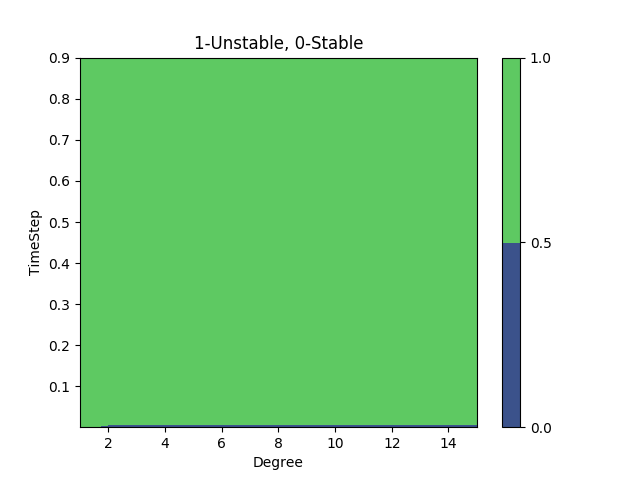

Text(0, 0.5, 'TimeStep')

In [255]:
%matplotlib notebook
x_plot,y_plot =np.meshgrid(deg,DT)
fig,ax=plt.subplots(1,1)
cf=ax.contourf(x_plot,y_plot,stability_reg2,[0,0.5,1])
fig.colorbar(cf)
plt.title('1-Unstable, 0-Stable')
plt.xlabel('Degree')
plt.ylabel('TimeStep')

In [245]:
Nel

16